ValueError: x and y can be no greater than 2-D, but have shapes (100,) and (100, 100, 3)

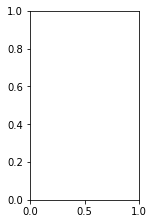

In [19]:
import numpy as np
from numpy import asarray
import scipy
import scipy.ndimage
from PIL import Image 
import matplotlib.pylab as plt
import time


def MTF(edgespreadfunction):
    '''
    Compute the modulation transfer function (MTF).
    The MTF is defined as the FFT of the line spread function.
    The line spread function is defined as the derivative of the edge spread
    function. The edge spread function are the values along an edge, ideally a
    knife-edge test target. See an explanation here: http://is.gd/uSC5Ve
    '''
    linespreadfunction = np.diff(edgespreadfunction)
    return np.abs(np.fft.fft(linespreadfunction))


def LSF(edgespreadfunction):
    '''
    Compute the modulation transfer function (MTF).
    The MTF is defined as the FFT of the line spread function.
    The line spread function is defined as the derivative of the edge spread
    function. The edge spread function are the values along an edge, ideally a
    knife-edge test target. See an explanation here: http://is.gd/uSC5Ve
    '''
    return np.abs(np.diff(edgespreadfunction))


def polynomialfit(data, order):
    '''
    calculate the polynomial fit of an input for a defined degree
    '''
    x, y = range(len(data)), data
    coefficients = np.polyfit(x, y, order)
    return np.polyval(coefficients, x)


# Generate edge for N points
N = 250

image=Image.open(r'C:\Users\bathu\Desktop\LR_beach1_patch.png')
im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
dirac = im_arr.reshape((image.size[0], image.size[1], 3)) 
#da=asarray(image)
#dirac = np.empty_like(da)
#dirac[:len(da)//2] = 1

# Filter edge
sigma = [0.4, 0.6, 1]
gauss_1 = scipy.ndimage.gaussian_filter(dirac, sigma=sigma[0])
gauss_2 = scipy.ndimage.gaussian_filter(dirac, sigma=sigma[1])
gauss_3 = scipy.ndimage.gaussian_filter(dirac, sigma=sigma[2])

SaveFigure = False
# Total = 55
# for iteration in range(Total):
#     print 'Plotting', iteration, 'of', Total

noise_sigma = 0.001
gauss_1_noise = gauss_1 + (noise_sigma * np.random.randn(len(dirac)), 1,2)
gauss_2_noise = gauss_2 + (noise_sigma * np.random.randn(len(dirac)), 1,2)
gauss_3_noise = gauss_3 + (noise_sigma * np.random.randn(len(dirac)), 1,2)


'''
Save the plots in a dictionary, so we can iterate through it afterwards. See
http://stackoverflow.com/a/2553532/323100 and http://is.gd/d008ai for reference
'''
plots = dict((name, eval(name)) for name in ['dirac',
                                             'gauss_1', 'gauss_1_noise',
                                             'gauss_2', 'gauss_2_noise',
                                             'gauss_3', 'gauss_3_noise'])

plt.figure(figsize=(16, 16))
counter = 0
ShowRegion = 10
for name, data in sorted(plots.items()):
    counter += 1
    plt.subplot(4, len(plots), counter)
    plt.plot(data)
    plt.ylim(-0.1, 1.1)
    # plt.xlim(len(dirac) / 2 - ShowRegion / 2, len(dirac) / 2 + ShowRegion /
    #          2)
    if name == 'dirac':
        plt.ylabel('Edge response')
    plt.title(name)
    if name == 'gauss_1':
        plt.title(name + '\nSigma=' + str(sigma[0]))
    if name == 'gauss_2':
        plt.title(name + '\nSigma=' + str(sigma[1]))
    if name == 'gauss_3':
        plt.title(name + '\nSigma=' + str(sigma[2]))

    plt.subplot(4, len(plots), counter + len(plots))
    plt.plot(LSF(data))
    plt.ylim(-0.1, 1.1)
    if name == 'dirac':
        plt.ylabel('Edge response')

    plt.subplot(4, len(plots), counter + 2 * len(plots))
    plt.plot(MTF(data))
    plt.plot(np.ones(N) * MTF(data)[len(dirac) // 2])
    plt.ylim(-0.1, 1.1)
    plt.xlim(0, len(dirac) / 2)
    if name == 'dirac':
        plt.ylabel('MTF @ Nyquist')
    plt.text(0.618 * len(dirac) / 2, MTF(data)[len(dirac) // 2] - 0.1,
             ' '.join([str(np.round(MTF(data)[len(dirac) // 2], 3) * 100),
                       '%']),
             fontsize=12, backgroundcolor='w')

    plt.subplot(4, len(plots), counter + 3 * len(plots))
    plt.plot(MTF(data), label='orig')
    # for degree in range(10,25):
    #     plt.plot(polynomialfit(MTF(data), degree), label=str(degree))
    # plt.legend()
    degree = 4
    plt.plot(polynomialfit(MTF(data), degree), label=str(degree), color='r')
    plt.plot(np.ones(N) * polynomialfit(MTF(data), degree)[len(dirac) // 2],
             color='g')
    plt.ylim(-0.1, 1.1)
    plt.xlim(0, len(dirac) // 2)
    if name == 'dirac':
        plt.ylabel(' '.join(['polynomial fit of order', str(degree),
                             '\nfitted MTF @ Nyquist']))
    plt.text(0.618 * len(dirac) // 2, MTF(data)[len(dirac) // 2] - 0.1,
             ' '.join([str(np.round(polynomialfit(MTF(data),
                                                  degree)[len(dirac) // 2],
                                    3) * 100), '%']),
             fontsize=12, backgroundcolor='w')

plt.subplot(4, len(plots), 1)
plt.plot(dirac, 'b')
plt.ylim(-0.1, 1.1)
plt.axvspan(len(dirac) // 2 - ShowRegion // 2, len(dirac) // 2 + ShowRegion // 2,
            facecolor='r', alpha=0.5)
plt.title('Ideal knife edge\n red zoom-region\n is shown right')

if SaveFigure:
    plt.savefig('MTF_' + str(int(time.time() * 10)) + '.png')
else:
    plt.show()